<p align = "center"><strong>LOCAL SPATIAL AUTOCORRELATION: GEARY I <strong></p>

<p><b>By: Jefferson C.</p>

---

#### __Geary’s C Local Bivariate__
__Def.__  

Medida **local de autocorrelación espacial** que cuantifica el grado de **disimilitud espacial** entre los valores de dos variables observadas en unidades espaciales vecinas, de acuerdo con una matriz de pesos espaciales.  
El índice local de Geary es **más sensible a diferencias locales** que el índice de Moran.

El índice toma los siguientes valores:
- $\to$ __0__ indica fuerte autocorrelación espacial positiva (valores similares),
- $\approx$ __1__ indica ausencia de autocorrelación espacial,
- $\to$ __> 1__ indica autocorrelación espacial negativa (valores disímiles).

__Formula:__

Suma de pesos espaciales:
$$
S_0 = \sum_{i=1}^{n} \sum_{j=1}^{n} w_{ij}
$$

Media y varianza global:
$$
\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i \quad \quad \bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i
$$

Índice local de Geary Bivariado:
$$
C_i = \frac{(n-1)}{2S_0} \frac{\sum_{j=1}^{n} w_{ij} (x_i - y_j)^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2 + \sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

<p align='center'> 
<em>El índice local de Geary bivariado evalúa la autocorrelación espacial a partir de las diferencias cuadráticas entre unidades vecinas para dos variables, siendo especialmente sensible a discontinuidades espaciales.</em>
</p>

donde:
- $w_{ij}$: elemento de la matriz de pesos espaciales $W$,
- $x_i$: valor observado de la primera variable de interés en la unidad espacial $i$,
- $y_j$: valor observado de la segunda variable de interés en la unidad espacial contigua (vecina de $x_i$),
- $n$: número de unidades espaciales,
- $\bar{x}$: media global de la primera variable,
- $\bar{y}$: media global de la segunda variable.

__Referencia:__
- Geary, R. C. (1954). *The contiguity ratio and statistical mapping*. The Incorporated Statistician, 5(3), 115–145.  
  https://www.jstor.org/stable/2986645


In [3]:
# DEPENDENCIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

import geopandas as gpd
from libpysal.weights import Queen, Rook, W, lag_spatial

from esda.geary import Geary               # Solo para referencia, no se usa directamente en BV
import warnings


def local_geary_bv(
    gdf,
    x_fields,
    y_fields,
    contiguities=("queen", "rook", "bishop"),
    permutations: int = 999,
    alpha: float = 0.05,
    drop_islands: bool = True,
    standardize_xy: bool = True,
    use_index: bool = True,
    figsize=(18, 12),
    style: str = "seaborn-v0_8",
    silence_warnings: bool = True,
    dashboard_pair: tuple[str, str] | None = None,
    seed: int | None = None,
):
    """
    Local Geary BIVARIADO para múltiples pares (X,Y) y 3 contigüidades (Queen/Rook/Bishop).
    
    Implementación manual siguiendo la fórmula GeoDa:
    c_i = Σ_j w_ij * (x_i - x_j) * (y_i - y_j)
    
    Returns:
      - results_table: tabla con estadísticos globales y conteos de significancia/clusters
      - fig: Dashboard para UN par (dashboard_pair):
             (1) scatter: z(x) vs lag(z(y)) [diagnóstico], con Global Geary BV C en título
             (2) Local Geary BV significance map (p bins)
             (3) Local Geary BV cluster map (GeoDa-like: HH, LL, Other Positive, Negative)
             repetido para cada contigüidad (rows)
      - out: dict con objetos detallados para el dashboard_pair
    
    Interpretación Local Geary Bivariado:
      - Valores BAJOS de c_i → asociación espacial POSITIVA entre x e y
      - Valores ALTOS de c_i → asociación espacial NEGATIVA entre x e y
    """
    
    # -------------------------
    # BASIC INPUT HANDLING
    # -------------------------
    if isinstance(x_fields, str):
        x_fields = [x_fields]
    if isinstance(y_fields, str):
        y_fields = [y_fields]
    
    x_fields = list(x_fields)
    y_fields = list(y_fields)
    
    # build (x,y) pairs with broadcast rules
    if len(x_fields) == len(y_fields):
        pairs = list(zip(x_fields, y_fields))
    elif len(y_fields) == 1:
        pairs = [(x, y_fields[0]) for x in x_fields]
    elif len(x_fields) == 1:
        pairs = [(x_fields[0], y) for y in y_fields]
    else:
        raise ValueError(
            "x_fields and y_fields must have same length, or one of them must have length 1."
        )
    
    # validate columns
    all_fields = set(x_fields + y_fields)
    missing = [c for c in all_fields if c not in gdf.columns]
    if missing:
        raise ValueError(f"These fields are missing in gdf: {missing}")
    
    contiguities = tuple(c.lower().strip() for c in contiguities)
    allowed = {"queen", "rook", "bishop"}
    if any(c not in allowed for c in contiguities):
        raise ValueError(f"contiguities must be in {allowed}")
    
    # Default dashboard pair
    if dashboard_pair is None:
        dashboard_pair = pairs[0]
    if dashboard_pair not in pairs:
        raise ValueError("dashboard_pair must be one of the generated (x,y) pairs")
    
    if not use_index:
        warnings.warn(
            "use_index=False may misalign island IDs with gdf.index when dropping islands. "
            "Recommended: use_index=True.",
            UserWarning,
        )
    
    # -------------------------
    # STYLE AND WARNINGS
    # -------------------------
    plt.style.use(style)
    
    if silence_warnings:
        warnings.filterwarnings(
            "ignore",
            category=UserWarning,
            message=".*weights matrix is not fully connected.*",
        )
        warnings.filterwarnings(
            "ignore",
            category=FutureWarning,
            message=".*use_index.*",
        )
    
    # -------------------------
    # HELPERS
    # -------------------------
    def build_w(df, kind):
        if kind == "queen":
            return Queen.from_dataframe(df, use_index=use_index)
        if kind == "rook":
            return Rook.from_dataframe(df, use_index=use_index)
        if kind == "bishop":
            wq = Queen.from_dataframe(df, use_index=use_index)
            wr = Rook.from_dataframe(df, use_index=use_index)
            ids = list(wq.id_order)
            neighbors = {}
            for i in ids:
                nq = set(wq.neighbors.get(i, []))
                nr = set(wr.neighbors.get(i, []))
                neighbors[i] = list(nq - nr)
            return W(neighbors, id_order=ids)
        raise ValueError("kind must be queen/rook/bishop")
    
    def zscore(v):
        v = np.asarray(v, dtype=float)
        sd = v.std(ddof=0)
        return (v - v.mean()) / sd if sd > 0 else v * 0.0
    
    def _bivariate_geary_global_c(x, y, w):
        """
        Calcula el Índice de Geary Bivariado Global.
        """
        n = len(x)
        
        x_std = zscore(x)
        y_std = zscore(y)
        
        w_array = w.full()[0]
        
        numerator = 0
        for i in range(n):
            for j in range(n):
                if i != j:
                    numerator += w_array[i, j] * (x_std[i] - x_std[j]) * (y_std[i] - y_std[j])
        
        w_sum = w_array.sum()
        denominator = 2 * w_sum * x_std.var(ddof=0) * y_std.var(ddof=0)
        
        if denominator == 0:
            return np.nan
            
        C = (n - 1) * numerator / denominator
        return C
    
    def _bivariate_geary_permutation(x, y, w, permutations=999, seed=None):
        """
        Prueba de permutaciones para Geary Bivariado Global.
        """
        if seed is not None:
            np.random.seed(seed)
            
        x_std = zscore(x)
        y_std = zscore(y)
        
        C_obs = _bivariate_geary_global_c(x_std, y_std, w)
        
        sim = np.zeros(permutations)
        for perm in range(permutations):
            y_perm = np.random.permutation(y_std)
            sim[perm] = _bivariate_geary_global_c(x_std, y_perm, w)
        
        # p-valor (two-sided)
        if C_obs < 1:
            p_sim = (np.sum(sim <= C_obs) + 1) / (permutations + 1)
        else:
            p_sim = (np.sum(sim >= C_obs) + 1) / (permutations + 1)
        
        # z-score
        z_sim = (C_obs - 1) / sim.std(ddof=1) if sim.std(ddof=1) > 0 else np.nan
        
        class Geary_BV_Result:
            pass
        
        result = Geary_BV_Result()
        result.C = C_obs
        result.sim = sim
        result.p_sim = p_sim
        result.z_sim = z_sim
        result.EC = 1.0
        
        return result
    
    def _local_geary_bv(x, y, w, permutations=999, seed=None):
        """
        Implementación de Local Geary Bivariado.
        
        Fórmula: c_i = Σ_j w_ij * (x_i - x_j) * (y_i - y_j)
        
        Returns:
            - localC: vector con valores de c_i
            - p_sim: p-valores basados en permutaciones
            - z_sim: z-scores
        """
        if seed is not None:
            np.random.seed(seed)
            
        n = len(x)
        
        # Estandarizar
        x_std = zscore(x)
        y_std = zscore(y)
        
        # Matriz de pesos densa
        w_array = w.full()[0]
        
        # Calcular c_i para cada observación
        localC = np.zeros(n)
        for i in range(n):
            for j in range(n):
                if i != j:
                    localC[i] += w_array[i, j] * (x_std[i] - x_std[j]) * (y_std[i] - y_std[j])
        
        # Prueba de permutaciones
        sim = np.zeros((n, permutations))
        for perm in range(permutations):
            y_perm = np.random.permutation(y_std)
            for i in range(n):
                c_perm = 0
                for j in range(n):
                    if i != j:
                        c_perm += w_array[i, j] * (x_std[i] - x_std[j]) * (y_perm[i] - y_perm[j])
                sim[i, perm] = c_perm
        
        # p-valores (pseudo-significancia)
        p_sim = np.zeros(n)
        z_sim = np.zeros(n)
        
        for i in range(n):
            # Para valores negativos (asociación positiva): cola inferior
            if localC[i] < np.mean(sim[i, :]):
                p_sim[i] = (np.sum(sim[i, :] <= localC[i]) + 1) / (permutations + 1)
            else:  # Para valores positivos (asociación negativa): cola superior
                p_sim[i] = (np.sum(sim[i, :] >= localC[i]) + 1) / (permutations + 1)
            
            z_sim[i] = (localC[i] - np.mean(sim[i, :])) / np.std(sim[i, :], ddof=1) if np.std(sim[i, :], ddof=1) > 0 else np.nan
        
        class LocalGearyBVResult:
            pass
        
        result = LocalGearyBVResult()
        result.localC = localC
        result.p_sim = p_sim
        result.z_sim = z_sim
        result.sim = sim
        
        return result
    
    # -------------------------
    # PRECOMPUTE WEIGHTS PER CONTIGUITY
    # -------------------------
    kinds = list(contiguities)
    by_kind = {}
    
    for kind in kinds:
        df2 = gdf.copy()
        w = build_w(df2, kind)
        islands_initial = list(getattr(w, "islands", []))
        
        if drop_islands and len(islands_initial) > 0:
            df2 = df2.drop(index=islands_initial).copy() if use_index else df2.copy()
            w = build_w(df2, kind)
        
        w.transform = "R"
        by_kind[kind] = {"gdf": df2, "w": w, "islands_initial": islands_initial}
    
    # -------------------------
    # RESULTS TABLE
    # -------------------------
    rows = []
    
    for (x_name, y_name) in pairs:
        for kind in kinds:
            df2 = by_kind[kind]["gdf"]
            w = by_kind[kind]["w"]
            islands_initial = by_kind[kind]["islands_initial"]
            
            x = df2[x_name].to_numpy()
            y = df2[y_name].to_numpy()
            
            n = len(x)
            
            # Caso degenerado
            if n < 3 or np.std(x, ddof=0) == 0 or np.std(y, ddof=0) == 0:
                rows.append({
                    "x": x_name,
                    "y": y_name,
                    "contiguity": kind.upper(),
                    "n": int(n),
                    "global_C": np.nan,
                    "global_p_perm": np.nan,
                    "permutations": int(permutations),
                    "alpha": float(alpha),
                    "islands_initial": int(len(islands_initial)),
                    "islands_removed": int(len(islands_initial)) if drop_islands else 0,
                    "islands_remaining": int(len(getattr(w, "islands", []))),
                    "sig_0_not": np.nan,
                    "sig_1_p05": np.nan,
                    "sig_2_p01": np.nan,
                    "sig_3_p001": np.nan,
                    "HH": np.nan,
                    "LL": np.nan,
                    "Other_Pos": np.nan,
                    "Negative": np.nan,
                    "note": "n<3 or zero variance in x or y",
                })
                continue
            
            # Global Geary Bivariado (con permutaciones)
            geary_bv = _bivariate_geary_permutation(x, y, w, permutations=permutations, seed=seed)
            
            # Local Geary Bivariado
            local_bv = _local_geary_bv(x, y, w, permutations=permutations, seed=seed)
            
            # Significance bins (basado en p_sim)
            p = local_bv.p_sim
            sig_class = np.zeros_like(p, dtype=int)
            sig_class[(p <= 0.05) & (p > 0.01)] = 1
            sig_class[(p <= 0.01) & (p > 0.001)] = 2
            sig_class[p <= 0.001] = 3
            
            sig_counts = pd.Series(sig_class).value_counts().reindex([0, 1, 2, 3], fill_value=0)
            
            # --- Cluster map GeoDa-like para BIVARIADO ---
            
            # z-scores de x e y
            x_std = zscore(x) if standardize_xy else x.copy()
            y_std = zscore(y) if standardize_xy else y.copy()
            
            # Para clusters bivariados, usamos:
            # - x_std para clasificar HH/LL en la variable X
            # - El producto cruzado localC para medir asociación
            z_x = x_std
            
            # Vecindario: lag de y (para clasificación)
            wy = lag_spatial(w, y_std)
            
            # Umbral de GeoDa: media de localC
            Eij_mean = float(np.mean(local_bv.localC))
            
            # Significancia
            sig_alpha = p <= alpha
            
            # Asociación positiva: localC BAJO (< media)
            positive = sig_alpha & (local_bv.localC < Eij_mean)
            # Asociación negativa: localC ALTO (>= media)
            negative = sig_alpha & (local_bv.localC >= Eij_mean)
            
            cl_class = np.zeros_like(p, dtype=int)
            # 0 Not Significant
            # 1 High-High (x alto, y alto en vecinos)
            # 2 Low-Low (x bajo, y bajo en vecinos)
            # 3 Other Positive (otras formas de asociación positiva)
            # 4 Negative (asociación negativa/dissimilar)
            
            # Positive spatial association
            cl_class[positive & (z_x > 0) & (wy > 0)] = 1  # HH
            cl_class[positive & (z_x < 0) & (wy < 0)] = 2  # LL
            cl_class[positive & ~((z_x > 0) & (wy > 0)) & ~((z_x < 0) & (wy < 0))] = 3  # Other Positive
            
            # Negative spatial association
            cl_class[negative] = 4
            
            cl_counts = pd.Series(cl_class).value_counts().reindex([0, 1, 2, 3, 4], fill_value=0)
            
            rows.append({
                "x": x_name,
                "y": y_name,
                "contiguity": kind.upper(),
                "n": int(n),
                "global_C": float(geary_bv.C),
                "global_p_perm": float(getattr(geary_bv, "p_sim", np.nan)),
                "permutations": int(permutations),
                "alpha": float(alpha),
                "islands_initial": int(len(islands_initial)),
                "islands_removed": int(len(islands_initial)) if drop_islands else 0,
                "islands_remaining": int(len(getattr(w, "islands", []))),
                "sig_0_not": int(sig_counts[0]),
                "sig_1_p05": int(sig_counts[1]),
                "sig_2_p01": int(sig_counts[2]),
                "sig_3_p001": int(sig_counts[3]),
                "HH": int(cl_counts[1]),
                "LL": int(cl_counts[2]),
                "Other_Pos": int(cl_counts[3]),
                "Negative": int(cl_counts[4]),
                "note": "",
            })
    
    results_table = pd.DataFrame(rows)
    
    order = pd.CategoricalDtype(["QUEEN", "ROOK", "BISHOP"], ordered=True)
    results_table["contiguity"] = results_table["contiguity"].astype(str).str.upper().astype(order)
    results_table = results_table.sort_values(["x", "y", "contiguity"]).reset_index(drop=True)
    
    # -------------------------
    # DASHBOARD palettes + legends
    # -------------------------
    sig_labels = ["Not Significant", "p ≤ 0.05", "p ≤ 0.01", "p ≤ 0.001"]
    sig_colors = ["#f0f0f0", "#a1d99b", "#41ab5d", "#005a32"]
    sig_cmap = ListedColormap(sig_colors)
    
    cl_labels = ["Not Significant", "High-High", "Low-Low", "Other Positive", "Negative"]
    cl_colors = ["#f0f0f0", "#8b0000", "#f4a261", "#f6d2b8", "#2b6cb0"]
    cl_cmap = ListedColormap(cl_colors)
    
    # -------------------------
    # DASHBOARD para el par seleccionado
    # -------------------------
    out = {"dashboard_pair": dashboard_pair, "by_contiguity": {}}
    
    fig, axes = plt.subplots(len(kinds), 3, figsize=figsize)
    if len(kinds) == 1:
        axes = np.array([axes])
    
    x_dash, y_dash = dashboard_pair
    
    for r, kind in enumerate(kinds):
        df2 = by_kind[kind]["gdf"]
        w = by_kind[kind]["w"]
        islands_initial = by_kind[kind]["islands_initial"]
        
        x = df2[x_dash].to_numpy()
        y = df2[y_dash].to_numpy()
        
        # Global Geary Bivariado (para título)
        geary_bv = _bivariate_geary_permutation(x, y, w, permutations=permutations, seed=seed)
        
        # Local Geary Bivariado
        local_bv = _local_geary_bv(x, y, w, permutations=permutations, seed=seed)
        
        p = local_bv.p_sim
        localC = local_bv.localC
        
        # Scatter: z(x) vs lag(z(y))  (diagnóstico bivariado)
        x_plot = zscore(x) if standardize_xy else x.copy()
        wy_plot = lag_spatial(w, zscore(y) if standardize_xy else y.copy())
        
        ax_sc = axes[r, 0]
        ax_sc.scatter(x_plot, wy_plot, edgecolor="k", facecolor="none", s=25)
        ax_sc.axhline(0, color="gray", linestyle="--", linewidth=1)
        ax_sc.axvline(0, color="gray", linestyle="--", linewidth=1)
        ax_sc.set_title(
            f"{kind.upper()} — z({x_dash}) vs lag(z({y_dash}))\n(Global C_xy={geary_bv.C:.3f}, p={geary_bv.p_sim:.4f})",
            fontweight="bold",
        )
        ax_sc.set_xlabel(f"{x_dash} ({'std' if standardize_xy else 'raw'})")
        ax_sc.set_ylabel(f"Spatial lag of {y_dash}")
        
        # Significance classes
        sig_class = np.zeros_like(p, dtype=int)
        sig_class[(p <= 0.05) & (p > 0.01)] = 1
        sig_class[(p <= 0.01) & (p > 0.001)] = 2
        sig_class[p <= 0.001] = 3
        sig_counts = pd.Series(sig_class).value_counts().reindex([0, 1, 2, 3], fill_value=0)
        
        # --- Cluster map GeoDa-like para BIVARIADO ---
        
        # z-scores
        z_x = zscore(x) if standardize_xy else x.copy()
        z_y = zscore(y) if standardize_xy else y.copy()
        
        # Lag de y (para clasificación)
        wy = lag_spatial(w, z_y)
        
        # Umbral: media de localC
        Eij_mean = float(np.mean(localC))
        
        sig_alpha = p <= alpha
        positive = sig_alpha & (localC < Eij_mean)
        negative = sig_alpha & (localC >= Eij_mean)
        
        cl_class = np.zeros_like(p, dtype=int)
        # 0 Not Significant
        # 1 High-High (x alto, y alto en vecinos)
        # 2 Low-Low (x bajo, y bajo en vecinos)
        # 3 Other Positive
        # 4 Negative
        
        # Positive spatial association
        cl_class[positive & (z_x > 0) & (wy > 0)] = 1  # HH
        cl_class[positive & (z_x < 0) & (wy < 0)] = 2  # LL
        cl_class[positive & ~((z_x > 0) & (wy > 0)) & ~((z_x < 0) & (wy < 0))] = 3  # Other Positive
        
        # Negative spatial association
        cl_class[negative] = 4
        
        cl_counts = pd.Series(cl_class).value_counts().reindex([0, 1, 2, 3, 4], fill_value=0)
        
        gdf_plot = df2.copy()
        gdf_plot["_sig_class"] = sig_class
        gdf_plot["_cl_class"] = cl_class
        
        # Significance map
        ax_sig = axes[r, 1]
        gdf_plot.plot(
            column="_sig_class",
            categorical=True,
            cmap=sig_cmap,
            linewidth=0.4,
            edgecolor="white",
            ax=ax_sig,
        )
        ax_sig.set_axis_off()
        ax_sig.set_title(f"{kind.upper()} — Local Geary BV Significance\n(perms={permutations})", fontweight="bold")
        sig_legend = [
            Patch(facecolor=sig_colors[i], edgecolor="k",
                  label=f"{sig_labels[i]} ({int(sig_counts[i])})")
            for i in range(4)
        ]
        ax_sig.legend(handles=sig_legend, loc="lower left", frameon=True, fontsize=8)
        
        # Cluster map
        ax_cl = axes[r, 2]
        gdf_plot.plot(
            column="_cl_class",
            categorical=True,
            cmap=cl_cmap,
            linewidth=0.4,
            edgecolor="white",
            ax=ax_cl,
        )
        ax_cl.set_axis_off()
        ax_cl.set_title(f"{kind.upper()} — Local Geary BV Cluster (α={alpha})\n{x_dash} vs {y_dash}", fontweight="bold")
        cl_legend = [
            Patch(facecolor=cl_colors[i], edgecolor="k",
                  label=f"{cl_labels[i]} ({int(cl_counts[i])})")
            for i in range(5)
        ]
        ax_cl.legend(handles=cl_legend, loc="lower left", frameon=True, fontsize=8)
        
        out["by_contiguity"][kind] = {
            "gdf": gdf_plot,
            "w": w,
            "x": x,
            "y": y,
            "geary_global_bv": geary_bv,
            "geary_local_bv": local_bv,
            "x_plot": x_plot,
            "wy_plot": wy_plot,
            "islands_initial": islands_initial,
            "Eij_mean": Eij_mean,
            "sig_class": sig_class,
            "cl_class": cl_class,
        }
    
    fig.suptitle(
        f"LOCAL GEARY BIVARIATE — {x_dash} vs {y_dash}",
        y=1.02,
        fontsize=14,
        fontweight="bold"
    )
    fig.tight_layout()
    
    return results_table, fig, out

,x,y,contiguity,n,global_C,global_p_perm,permutations,alpha,islands_initial,islands_removed,islands_remaining,sig_0_not,sig_1_p05,sig_2_p01,sig_3_p001,HH,LL,Other_Pos,Negative,note
0,BirthRate,Below_evel,QUEEN,77,6.115478,0.219,999,0.05,0,0,0,75,2,0,0,0,1,1,0,
1,BirthRate,Below_evel,ROOK,77,6.912107,0.174,999,0.05,0,0,0,74,3,0,0,0,1,1,1,
2,BirthRate,Below_evel,BISHOP,31,0.426367,0.548,999,0.05,46,46,0,31,0,0,0,0,0,0,0,


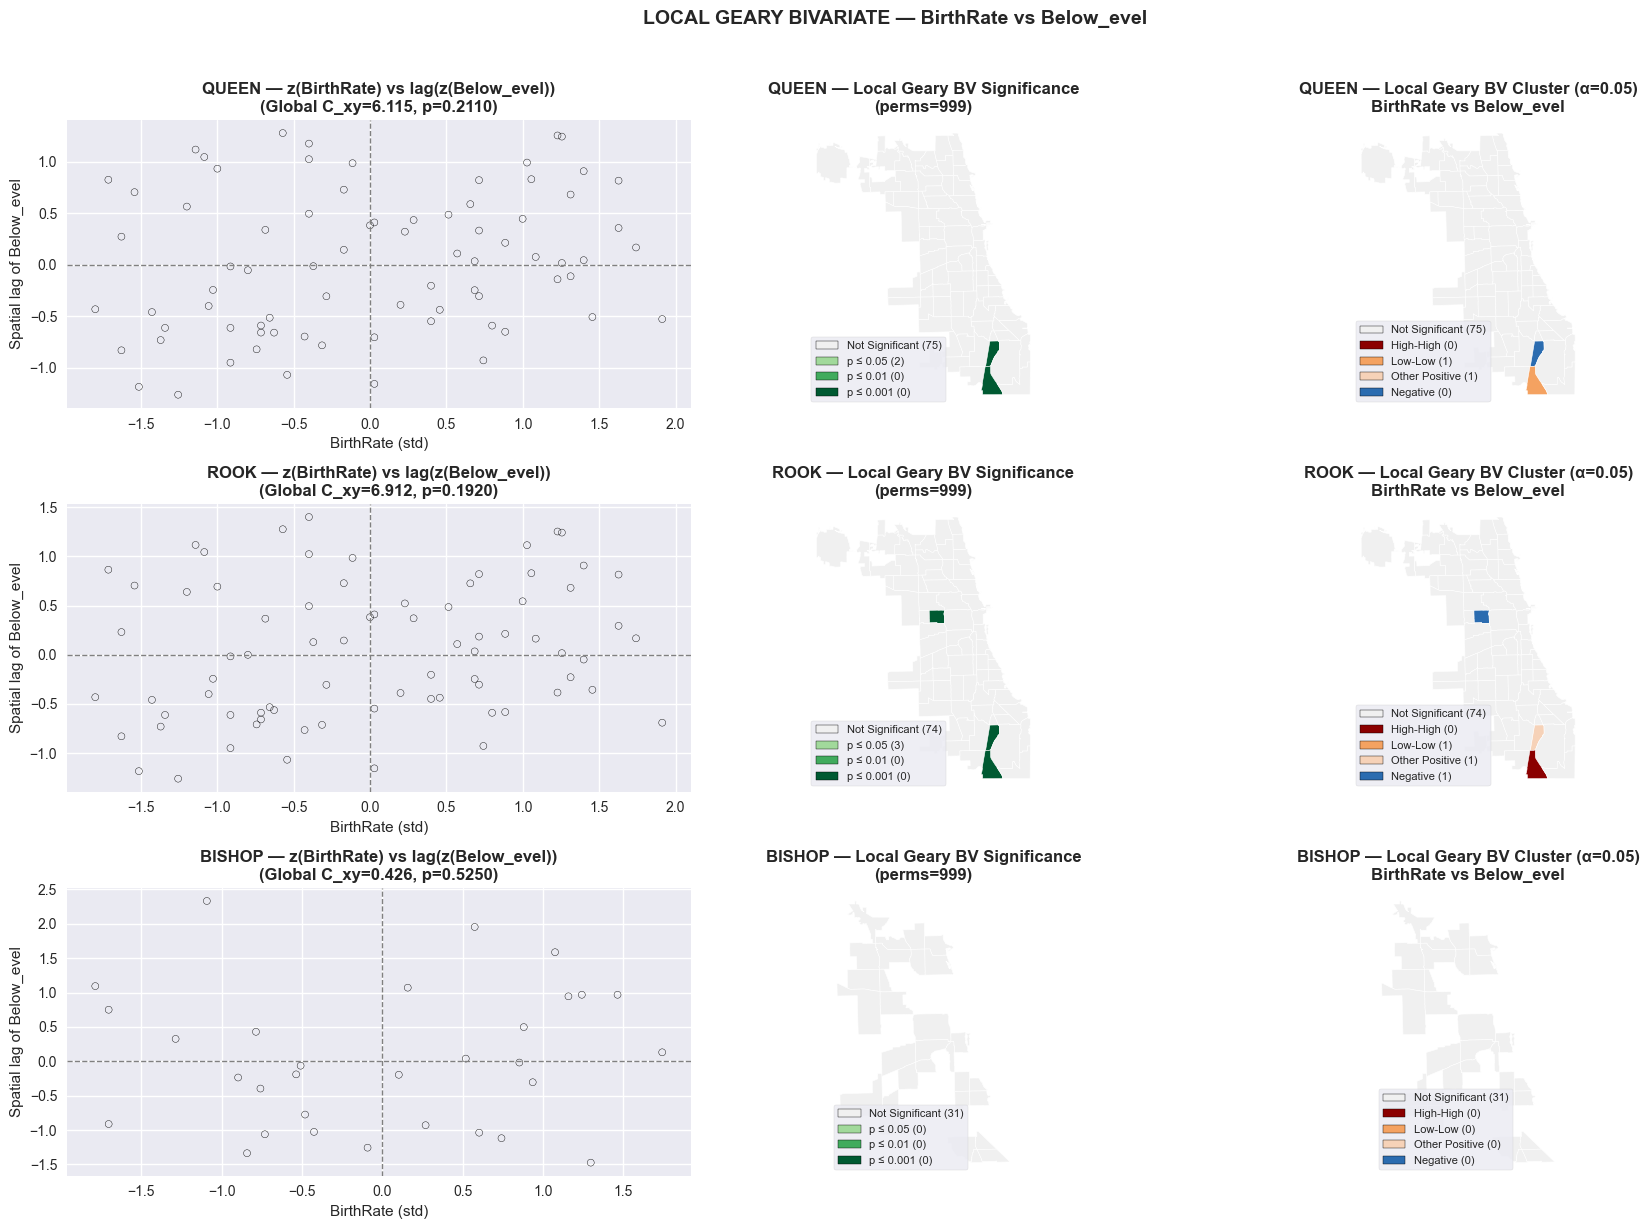

In [4]:
gdf = gpd.read_file("../Data Bases/healthindicators/HealthIndicators.shp")

tab, fig, out = local_geary_bv(
    gdf=gdf,
    x_fields=["BirthRate"],
    y_fields=["Below_evel"],
    contiguities=("queen", "rook", "bishop"),
    permutations=999,
    alpha=0.05,
    standardize_xy=True,
    dashboard_pair=("BirthRate", "Below_evel"),
)

display(tab)
plt.show()

---